In [17]:
import lava.lib.dl.slayer as slayer
import matplotlib.pyplot as plt
import numpy as np
import nir
import norse
import tonic
import torch
import tqdm
import importlib
import lava_cnn_reader
importlib.reload(lava_cnn_reader);

In [18]:
graph = nir.read('scnn_mnist.nir')
norse_graph = norse.torch.from_nir(graph)
children = list(norse_graph.children())
net = lava_cnn_reader.nir_to_lava_dl(graph)

In [19]:
bs = 128
collate = tonic.collation.PadTensors(batch_first=False)
to_frame = tonic.transforms.ToFrame(sensor_size=tonic.datasets.NMNIST.sensor_size, time_window=1e3)
test_ds = tonic.datasets.NMNIST("./nmnist", transform=to_frame, train=False)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=bs, collate_fn=collate)

In [16]:
accuracies = []
pbar = tqdm.tqdm(total=len(test_dl), desc="Processing", position=0, leave=True)

for idx, (x, y) in enumerate(test_dl):
    x = torch.moveaxis(x, 0, -1)
    out = net(x)
    pred = out.mean(axis=-1).argmax(axis=1)
    accuracy = (pred == y).sum() / x.shape[0]
    accuracies.append(accuracy)
    pbar.set_postfix(accuracy="{:.2f}%".format(sum(accuracies)/len(accuracies)*100))
    pbar.update(1)
pbar.close()
accuracies = np.array(accuracies)
print(f'accuracy: {accuracies.mean():.2%} +/- {accuracies.std():.2%}')

Processing: 100%|██████████| 79/79 [17:43<00:00, 13.46s/it, accuracy=98.15%]

accuracy: 98.15% +/- 1.03%


In [ ]:
print(accuracies.shape)

## debug: make sure norse and lava are equal

In [ ]:
lens = [len(net.blocks), len(children)]
assert lens[0] == lens[1]

sample_idx = 0
inp = test_ds[sample_idx][0]

lava_outputs = {}
lava_hidden = {}
norse_outputs = {}
norse_hidden = {}
for idx in range(lens[0]):
    lavablock = net.blocks[idx]
    norseblock = children[[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 2, 3, 4][idx]]
    print(f'block {idx:02}: {type(lavablock).__name__:10} {type(norseblock).__name__:10}')

    if idx == 0:
        x_lava = torch.Tensor(inp).moveaxis(0, -1).unsqueeze(0)
        x_norse = torch.Tensor(inp)
        print('x_lava', x_lava.shape, 'x_norse', x_norse.shape)

    # lava forward pass
    x = lava_outputs[idx-1] if idx > 0 else x_lava
    if isinstance(lavablock, slayer.neuron.cuba.Neuron):
        lava_outputs[idx], lava_hidden[idx] = lavablock.forward(x, debug=True)
        assert torch.allclose(lava_outputs[idx].detach(), lavablock(x).detach())
    else:
        lava_outputs[idx] = lavablock(x)

    # norse forward pass
    x = norse_outputs[idx-1] if idx > 0 else x_norse
    if isinstance(norseblock, norse.torch.IAFCell):
        T = x.shape[0]
        outs = [None for _ in range(T)]
        vs = [None for _ in range(T)]
        for t in range(T):
            outs[t], vs[t] = norseblock(x[t], vs[t-1] if t > 0 else None)
        norse_outputs[idx] = torch.concat(outs, dim=0)
        norse_hidden[idx] = torch.concat([v.v for v in vs], dim=0)
    else:
        norse_outputs[idx] = norseblock(x)
    if isinstance(x, tuple):
        print(x)

    # print(f'block {idx:02}: {type(lavablock)} {type(norseblock)}')
    print('close:', torch.allclose(lava_outputs[idx].squeeze(0).moveaxis(-1, 0), norse_outputs[idx], atol=1e-5, rtol=1e-5))

block 00: Conv       Conv2d    
x_lava torch.Size([1, 2, 34, 34, 308]) x_norse torch.Size([308, 2, 34, 34])
close: True
block 01: Neuron     IAFCell   
close: True
block 02: Conv       Conv2d    
close: False
block 03: Neuron     IAFCell   
close: True
block 04: Pool       LPPool2d  
close: True
block 05: Conv       Conv2d    
close: False
block 06: Neuron     IAFCell   
close: True
block 07: Pool       LPPool2d  
close: True
block 08: Flatten    Flatten   
close: True
block 09: Dense      Linear    
close: True
block 10: Neuron     IAFCell   
close: True
block 11: Dense      Linear    
close: True
block 12: Neuron     IAFCell   
close: True


In [ ]:
# check that the Conv weights are the same
print('W:', np.allclose(children[0].weight.detach(), net.blocks[0].weight.squeeze(-1).detach()))
print(f'stride: \tnorse {children[0].stride}\t lava-dl {net.blocks[0].stride}')
print(f'padding: \tnorse {children[0].padding}\t lava-dl {net.blocks[0].padding}')
print(f'dilation: \tnorse {children[0].dilation}\t lava-dl {net.blocks[0].dilation}')
print(f'groups: \tnorse {children[0].groups}\t\t lava-dl {net.blocks[0].groups}')

W: True
stride: 	norse (2, 2)	 lava-dl (2, 2, 1)
padding: 	norse (1, 1)	 lava-dl (1, 1, 0)
dilation: 	norse (1, 1)	 lava-dl (1, 1, 1)
groups: 	norse 1		 lava-dl 1


Layer #0: Convolution
out_lava torch.Size([16, 16, 16, 308])
out_norse torch.Size([16, 16, 16, 308])
all close True
norse weight min -1.79 max 0.51
lava weight  min -1.79 max 0.51

Layer #1: I&F
if_lava torch.Size([16, 16, 16, 308])
if_norse torch.Size([16, 16, 16, 308]) torch.Size([16, 16, 16, 308])
norse v_reset tensor(0., requires_grad=True)
norse v_thr tensor([1.])
norse v: min -68.921, max   1.000
lava v:  min -68.921, max   2.728


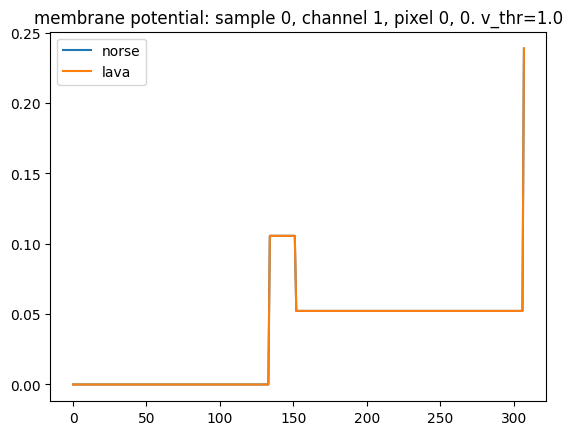

In [74]:
sample_idx = 0

inp_lava = torch.ones(1, 2, 34, 34, 10)
inp_norse = torch.ones(10, 2, 34, 34)

inp_lava = torch.Tensor(test_ds[0][0]).moveaxis(0, -1).unsqueeze(0)
inp_norse = torch.Tensor(test_ds[0][0])

print('Layer #0: Convolution')
out_lava = net.blocks[0](inp_lava).squeeze(0).detach()
out_norse = children[0](inp_norse).moveaxis(0, -1).detach()
print('out_lava', out_lava.shape)
print('out_norse', out_norse.shape)
print('all close', np.allclose(out_lava, out_norse))
print(f'norse weight min {children[0].weight.min():.2f} max {children[0].weight.max():.2f}')
print(f'lava weight  min {net.blocks[0].weight.min():.2f} max {net.blocks[0].weight.max():.2f}')

print('\nLayer #1: I&F')
if_lava, v = net.blocks[1](out_lava.unsqueeze(0), debug=True)
if_lava = if_lava.squeeze(0).detach()
v_lava = v.squeeze(0).detach()
# thr_lava = thr.squeeze(0).detach()
# refr_lava = refr.squeeze(0).detach()
# assert len(np.unique(thr_lava)) == 1, 'threshold must be the same for all neurons'
# assert len(np.unique(refr_lava)) == 1, 'refractory must be the same for all neurons'
s_norse = []
v_norse = []
v = None
for t in range(out_norse.shape[-1]):
    s, v = children[1](out_norse[..., t], v)
    s_norse.append(s.detach())
    v_norse.append(v.v.detach())
s_norse = torch.stack(s_norse, dim=-1).squeeze(0)
v_norse = torch.stack(v_norse, dim=-1).squeeze(0)
# if_norse, if_norse_v = children[1](out_norse.moveaxis(-1, 0))
# if_norse = if_norse.moveaxis(0, -1).detach()
# v_norse = if_norse_v.v.moveaxis(0, -1).detach()
print('if_lava', if_lava.shape)
print('if_norse', s_norse.shape, v_norse.shape)

print('norse v_reset', children[1].p.v_reset)
print('norse v_thr', children[1].p.v_th.unique())
print(f'norse v: min {v_norse.min().item():7.3f}, max {v_norse.max().item():7.3f}')
print(f'lava v:  min {v_lava.min().item():7.3f}, max {v_lava.max().item():7.3f}')

idx = 1
px_x = 0
px_y = 0
plt.title(f'membrane potential: sample {sample_idx}, channel {idx}, pixel {px_x}, {px_y}. v_thr={children[1].p.v_th.unique()[0]}')
plt.plot(v_norse[idx, px_x, px_y, :], label='norse')
# spike_idxs = np.where(if_norse[idx, 0, 0, :] == 1)[0]
# plt.scatter(spike_idxs, np.ones_like(spike_idxs))
plt.plot(v_lava[idx, px_x, px_y, :], label='lava')
# spike_idxs = np.where(if_lava[idx, 0, 0, :] == 1)[0]
# plt.scatter(spike_idxs, np.ones_like(spike_idxs))
plt.legend()
plt.show()

## check lava-dl ALIF neuron parameters


### cuba

In [15]:
v_thr_eff = 1.
cuba_neuron_params = dict(
    threshold=v_thr_eff, 
    # threshold_step=0.0, 
    current_decay=1.0,
    voltage_decay=0.0,
    scale=4096,
    # refractory_decay=1.0,
    # threshold_decay=0.0,
)
neuron = slayer.neuron.cuba.Neuron(**cuba_neuron_params)
inp = torch.Tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]) * 0.5
s, v = neuron.forward(inp.reshape((1, 1, -1)), debug=True)

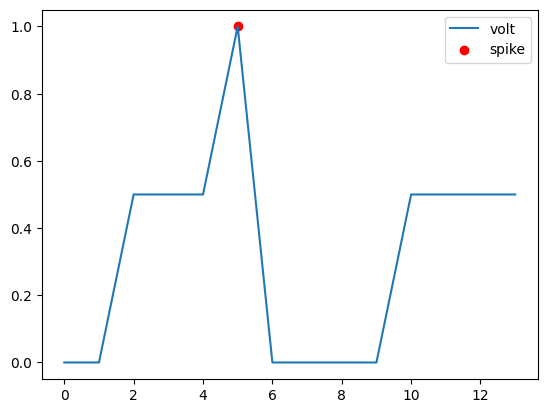

In [16]:
plt.plot(v.flatten(), label='volt')
evts = np.where(s.flatten() == 1)[0]
plt.scatter(evts, len(evts)*[1], label='spike', c='red')
# plt.eventplot(np.where(s.flatten() == 1), lineoffsets=1, linelengths=0.2, color='red', label='spike')
plt.legend()
plt.show()

### alif

In [133]:
v_thr_eff = 1.
alif_neuron_params = dict(
    threshold=v_thr_eff, threshold_step=0.0, scale=4096,
    refractory_decay=1.0,
    current_decay=1.0,
    voltage_decay=0.0,
    threshold_decay=0.0,
)
neuron = slayer.neuron.alif.Neuron(**alif_neuron_params)
inp = torch.Tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
s, v, thr, ref = neuron.forward(inp.reshape((1, 1, -1)), debug=True)

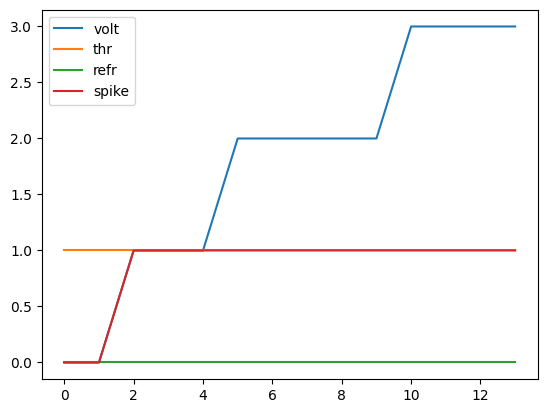

In [135]:
plt.plot(v.flatten(), label='volt')
plt.plot(thr.flatten(), label='thr')
plt.plot(ref.flatten(), label='refr')
plt.plot(s.flatten(), label='spike')
plt.legend()
plt.show()

## lava-dl testing

In [195]:
pool_synapse_params = dict(
    kernel_size=(3, 3), stride=1, padding=0, dilation=1, 
    weight_scale=1, weight_norm=False, pre_hook_fx=None
)
conv_synapse_params = dict(
    in_features=1, out_features=1, 
    kernel_size=(2, 2), stride=1, padding=0, dilation=1, groups=1,
    weight_scale=1, weight_norm=False, pre_hook_fx=None
)
conv_block_add_params = dict(
    delay_shift=False, delay=False, count_log=False
)
alif_neuron_params = dict(
    threshold=1.0, threshold_step=1.0, current_decay=0.0, voltage_decay=0.0,
    threshold_decay=0.0, refractory_decay=0.0, scale=4096
)

slayer.block.alif.Pool(neuron_params=alif_neuron_params, **pool_synapse_params)
slayer.block.alif.Conv(neuron_params=alif_neuron_params, **conv_synapse_params, **conv_block_add_params)
slayer.synapse.Conv(**conv_synapse_params)
slayer.synapse.Pool(**pool_synapse_params)

Pool(1, 1, kernel_size=(3, 3, 1), stride=(1, 1, 1), bias=False)

In [196]:
class Network(torch.nn.Module):
    def __init__(self, block=True):
        super(Network, self).__init__()
        if block:
            self.blocks = torch.nn.ModuleList([
                slayer.block.alif.Conv(neuron_params=alif_neuron_params, **conv_synapse_params, **conv_block_add_params),
                # slayer.block.alif.Conv(alif_neuron_params, **conv_synapse_params),
                # slayer.block.alif.Pool(alif_neuron_params, **pool_synapse_params),
            ])
            self.blocks[0].synapse.weight.data = torch.ones_like(self.blocks[0].synapse.weight) * 2
            print(self.blocks[0].synapse.weight.reshape(-1).detach())
        else:
            self.blocks = torch.nn.ModuleList([
                slayer.synapse.Conv(**conv_synapse_params),
                slayer.neuron.alif.Neuron(**alif_neuron_params),
                # slayer.synapse.Pool(**pool_synapse_params),
            ])
            self.blocks[0].weight.data = torch.ones_like(self.blocks[0].weight) * 2
            print(self.blocks[0].weight.reshape(-1).detach())
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike

In [202]:
for use_block in [True, False]:
    net = Network(use_block)
    # expects NCHWT
    u = torch.ones((1, 1, 10, 10, 20)) * 0.02
    y = net(u)
    print(f'output shape: {list(y.shape)}, sum: {y.sum().item()}')

tensor([2., 2., 2., 2.])
output shape: [1, 1, 9, 9, 20], sum: 405.0
tensor([2., 2., 2., 2.])
output shape: [1, 1, 9, 9, 20], sum: 405.0


## attempt to use lava

In [ ]:
from lava.proc.lif.process import LIF
lava_graph = {}

for nkey, node in graph.nodes.items():
    if isinstance(node, nir.ir.IF):
        assert node.r.shape == node.v_threshold.shape
        # NOTE: check for lava constraints
        assert len(np.unique(node.r)) == 1, 'must have some R across population'
        assert len(np.unique(node.v_threshold)) == 1, 'must have some Vth across population'
        # set IF parameters
        du = 1.0  # no dynamics on current
        dv = 0.0  # no voltage decay
        vth = np.unique(node.v_threshold)[0] * np.unique(node.r)[0]
        # discretize
        du = int(du * 4095)
        dv = int(dv * 4095)
        vth = int(vth * 131071) >> 9
        vth = vth // 256  # this can also be done by scaling the weights
        # save node into graph
        lava_graph[nkey] = LIF(shape=node.r.shape, du=du, dv=dv, vth=vth, name=nkey)

        # th, ref = slayer.neuron.dynamics.adaptive_threshold.dynamics(
        #     voltage,                                # dynamics state
        #     ref_state=torch.FloatTensor([0.]),      # discable - previous refractory state
        #     ref_decay=torch.FloatTensor([scale]),   # disable - constant refractory
        #     th_state=thr0,                          # previous threshold state
        #     th0=thr0,                               # threshold stable state
        #     th_decay=torch.FloatTensor([0.]),       # (doesn't matter) - threshold decay
        #     th_scale=torch.FloatTensor([0.]),       # disable - threshold step
        #     w_scale=scale,                          # fixed precision scaling
        # )
    # elif isinstance(node, nir.ir.Affine):
        

IF population with threshold: 1.0
(1, 16, 16, 16)
IF population with threshold: 1.0
(1, 256)
IF population with threshold: 1.0
(1, 10)
IF population with threshold: 1.0
(1, 16, 16, 16)
IF population with threshold: 1.0
(1, 8, 8, 8)


In [49]:
FIXED_PT = True

# IF parameters
du = 1.0
dv = 0.0
vth = 5.0

# discretize
if FIXED_PT:
    du = int(du * 4095)
    dv = int(dv * 4095)
    vth = int(vth * 131071) >> 9
    vth = vth // 256  # this can also be done by scaling the weights

In [50]:
from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer

ring_buffer = RingBuffer(data=np.array(10*[0, 0, 0, 1, 0, 0, 0, 0, 0]).reshape(1, -1))
lif = LIF(
    shape=(1,),
    # u=0.,
    # v=0.,
    du=du,  # infinite current leak
    dv=dv,  # no voltage leak
    vth=vth,
    # no bias
    bias_mant=0,
    bias_exp=0,
    name='lif'
)

ring_buffer.s_out.connect(lif.a_in)

from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg, Loihi1SimCfg, Loihi2HwCfg, Loihi1HwCfg

n_steps = 100

smon = Monitor()
smon.probe(lif.s_out, n_steps)
vmon = Monitor()
vmon.probe(lif.v, n_steps)
umon = Monitor()
umon.probe(lif.u, n_steps)

tag = "fixed_pt" if FIXED_PT else "floating_pt"
run_cfg = Loihi2SimCfg(select_tag=tag)
lif.run(condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg)

scale threshold. effective: 256


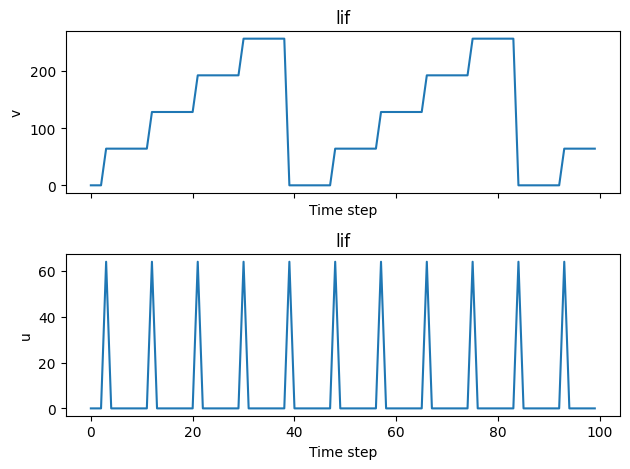

In [51]:
# plt.plot(vmon.get_data()['lif.v'])
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, sharex=True)
vmon.plot(axs[0], lif.v)
umon.plot(axs[1], lif.u)
plt.tight_layout()